In [ ]:
!pip install bs4
!pip install requests
!pip install panda
!pip install requestsexceptions

In [ ]:
import requests
from bs4 import BeautifulSoup
import string
import csv
import time
from http.client import IncompleteRead
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock

# Function to fetch URLs with retry mechanism
def fetch_url_with_retry(url, retries=3, backoff_factor=2):
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10)
            return response.text
        except (IncompleteRead, requests.exceptions.RequestException) as e:
            print(f"Error fetching {url}: {e}. Attempt {attempt + 1} of {retries}.")
            time.sleep(backoff_factor * (attempt + 1))  # Wait before retrying
            continue
    return None

# Function to scrape details from a recipe page and write to the CSV
def scrape_recipe(recipe_name, recipe_link, lock):
    try:
        # Fetch the individual recipe page
        inner_html_text = fetch_url_with_retry(recipe_link)
        if not inner_html_text:
            return

        inner_soup = BeautifulSoup(inner_html_text, 'lxml')

        # Extract ingredients
        ingredients_elements = inner_soup.findAll('li', class_='recipe-ingredients__list-item')
        ingredients = [item.find('a').text.strip() for item in ingredients_elements if item.find('a')]

        # Extract instructions
        instructions_elements = inner_soup.findAll('li', class_='recipe-method__list-item')
        instructions = ' '.join([' '.join(instruction.text.split()) for instruction in instructions_elements])

        # Extract cooking time
        recipe_cookings_elements = inner_soup.findAll('p', class_='recipe-metadata__cook-time')
        cooking_time = recipe_cookings_elements[0].text.strip() if recipe_cookings_elements else None

        # Extract servings
        recipe_servings_elements = inner_soup.findAll('p', class_='recipe-metadata__serving')
        servings = recipe_servings_elements[0].text.strip() if recipe_servings_elements else None

        # Extract preparation time
        recipe_preptimes_elements = inner_soup.findAll('p', class_='recipe-metadata__prep-time')
        preparation_time = recipe_preptimes_elements[0].text.strip() if recipe_preptimes_elements else None

        # Ensure that writing to the CSV is thread-safe using a lock
        with lock:
            with open('scraped_recipes.csv', mode='a', newline='', encoding='utf-8') as file:
                writer = csv.writer(file)
                writer.writerow([recipe_name, recipe_link, ', '.join(ingredients), instructions, cooking_time, servings, preparation_time])

    except Exception as e:
        print(f"Error processing recipe {recipe_name}: {e}")

# Function to scrape a page and submit recipes for multithreading
def scrape_page(character, i):
    try:
        # Fetch the page content for each letter and page number
        url = f'https://www.bbc.co.uk/food/recipes/a-z/{character}/{i}'
        html_text = fetch_url_with_retry(url)
        if not html_text:
            return []

        soup = BeautifulSoup(html_text, 'lxml')

        # Find recipe names and links
        recipe_name_elements = soup.findAll('h3', class_='promo__title')
        recipe_link_elements = soup.findAll('a', class_='promo')

        recipes = [(recipe_name.text.strip(), 'https://www.bbc.co.uk' + link['href'])
                   for recipe_name, link in zip(recipe_name_elements, recipe_link_elements)]

        return recipes

    except requests.exceptions.RequestException as e:
        print(f"Error fetching page {character}/{i}: {e}")
        return []

# Create a CSV file and write the headers
with open('scraped_recipes.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Recipe Name', 'Recipe Link', 'Ingredients', 'Instructions', 'Cooking Time', 'Servings', 'Preparation Time'])

# Create a lock for thread-safe writing
lock = Lock()

# Multithreading to scrape pages concurrently
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    for character in string.ascii_lowercase:
        for i in range(1, 22):
            futures.append(executor.submit(scrape_page, character, i))

    # Collect the results for each page
    for future in as_completed(futures):
        recipes = future.result()
        if recipes:
            # Use additional threads to process individual recipes
            with ThreadPoolExecutor(max_workers=10) as recipe_executor:
                recipe_futures = [recipe_executor.submit(scrape_recipe, recipe_name, recipe_link, lock)
                                  for recipe_name, recipe_link in recipes]
                for _ in as_completed(recipe_futures):
                    pass  # No return value, but waiting for all recipes to complete

print("Data has been incrementally saved to 'scraped_recipes.csv'.")


Data has been incrementally saved to 'scraped_recipes.csv'.


#Now doing the make the dataset recipe id and ingredients

In [26]:
import pandas as pd
import spacy
import random

In [27]:
spacy.cli.download("en_core_web_lg") #downloading the large model _lg
nlp = spacy.load("en_core_web_lg") #load it 

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [41]:
file_path = 'scraped_recipes.csv'
recipes_data = pd.read_csv(file_path, on_bad_lines='skip')


In [42]:
recipes_data['Recipe_ID'] = ['Recipe ' + str(i+1) for i in range(len(recipes_data))] #introducing the new recipe 1 ...2....n in the dataframe.
# for i in range(len(recipes_data)):
  # recipes_data['Recipes_ID'].append('Recipe ' + str(i+1))

recipes_data['Ingredients'] = recipes_data['Ingredients'].fillna('')

In [43]:
ingredient_entries = []
for idx, row in recipes_data.iterrows():
    recipe_id = row['Recipe_ID']
    ingredients = row['Ingredients']
    ingredients_list = ingredients.split(',')
    for ingredient in ingredients_list:
        ingredient = ingredient.strip()
        doc = nlp(ingredient)
        for ent in doc.ents:
                ingredient_entries.append((recipe_id, ent.text))


In [44]:
ingredient_df = pd.DataFrame(ingredient_entries, columns=['Recipe_ID', 'Ingredient_Name'])

In [45]:
ingredient_df.head(5)

,Recipe_ID,Ingredient_Name
0,Recipe 2,white pepper
1,Recipe 9,calvados
2,Recipe 10,garam masala
3,Recipe 10,star anise
4,Recipe 10,amchoor


In [46]:
ingredient_df.drop_duplicates(inplace=True)

In [47]:
ingredient_df.head(20)

,Recipe_ID,Ingredient_Name
0,Recipe 2,white pepper
1,Recipe 9,calvados
2,Recipe 10,garam masala
3,Recipe 10,star anise
4,Recipe 10,amchoor
5,Recipe 13,kirsch
6,Recipe 17,sriracha
7,Recipe 18,basmati
8,Recipe 18,aubergines
9,Recipe 18,garam masala


In [48]:
ingredient_df.to_csv('extracted_ingredients.csv', index=False)

In [49]:
# Open the text file in write mode
with open('extracted_ingredients.txt', 'w') as f:
    # Loop through each row in the DataFrame
    for index, row in ingredient_df.iterrows():
        # Write in the format (Recipe ID)—(Ingredient Name)
        f.write(f"{row['Recipe_ID']} — {row['Ingredient_Name']}\n")


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#(a) Find the number of unique ingredients. List them with their frequencies.

In [51]:
ingredient_frequencies = ingredient_df['Ingredient_Name'].value_counts().reset_index()
ingredient_frequencies.columns = ['Ingredient_Name', 'Frequency']

In [52]:
ingredient_frequencies.to_csv('unique_ingredients_frequencies.csv', index=False)

In [53]:
frequency_data=pd.read_csv('unique_ingredients_frequencies.csv')

In [54]:
print('The unique ingredients are::',len(frequency_data))

The unique ingredients are:: 222


In [55]:
frequency_data.head(10)

,Ingredient_Name,Frequency
0,cornflour,343
1,tarragon,185
2,garam masala,182
3,white pepper,159
4,star anise,155
5,basmati,155
6,Worcestershire,141
7,English,121
8,demerara sugar,112
9,white chocolate,92


#(b) Plot the recipe size distribution for these recipes and the average size of the recipes.


In [67]:
recipe_sizes = ingredient_df.groupby('Recipe_ID').size().reset_index(name='Recipe_Size')
recipe_sizes.head(100)

,Recipe_ID,Recipe_Size
0,Recipe 10,3
1,Recipe 1000,1
2,Recipe 1002,1
3,Recipe 1009,1
4,Recipe 101,2
...,...,...
95,Recipe 10602,1
96,Recipe 10603,2
97,Recipe 10604,1
98,Recipe 10605,2


In [66]:
average_recipe_size = round(recipe_sizes['Recipe_Size'].mean(), 2)
print(f"Average recipe size: {average_recipe_size}")

Average recipe size: 1.4


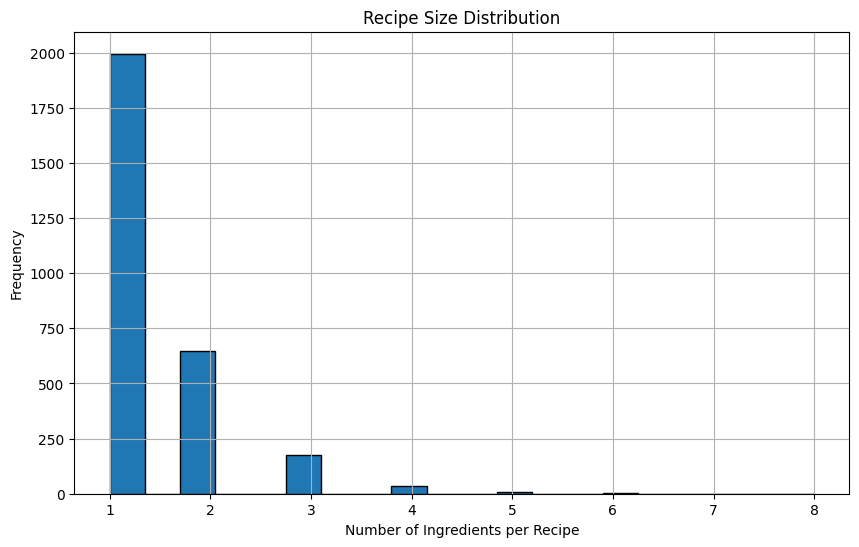

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(recipe_sizes['Recipe_Size'], bins=20, edgecolor='black')
plt.title('Recipe Size Distribution')
plt.xlabel('Number of Ingredients per Recipe')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('recipe_size_distribution.png')
plt.show()

#Plot cumulative distribution of recipe size (label axes properly).

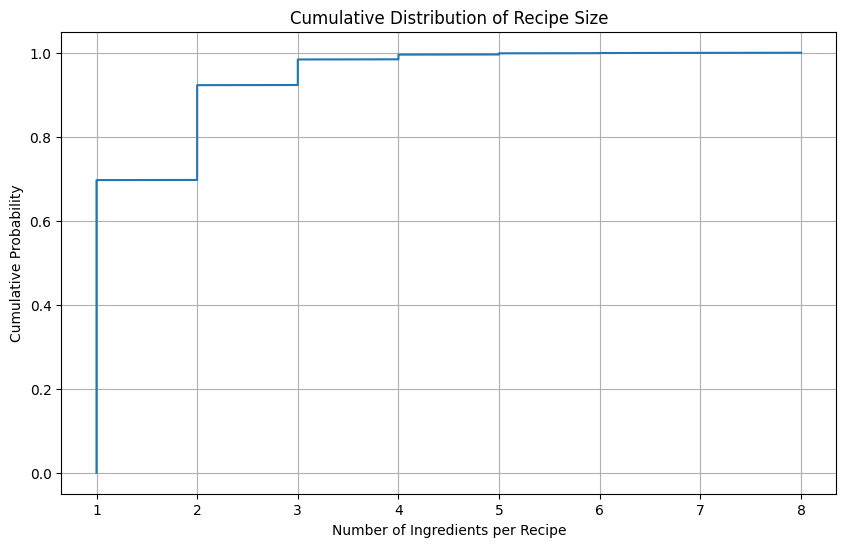

Plots saved as 'recipe_size_distribution.png' and 'recipe_size_cumulative_distribution.png'


In [68]:
plt.figure(figsize=(10, 6))
sorted_sizes = np.sort(recipe_sizes['Recipe_Size'])
y_vals = np.arange(len(sorted_sizes)) / float(len(sorted_sizes))

plt.plot(sorted_sizes, y_vals)
plt.title('Cumulative Distribution of Recipe Size')
plt.xlabel('Number of Ingredients per Recipe')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.savefig('recipe_size_cumulative_distribution.png')
plt.show()

print("Plots saved as 'recipe_size_distribution.png' and 'recipe_size_cumulative_distribution.png'")

#Plot the frequency-rank distribution. Scale and label axes properly.

In [69]:
ingredient_frequencies['Normalized Frequency'] = ingredient_frequencies['Frequency'] / ingredient_frequencies['Frequency'].sum()
# divinding by the sum leads to make normalisze the frequency 
ingredient_frequencies['Rank'] = ingredient_frequencies['Frequency'].rank(ascending=False, method='min')


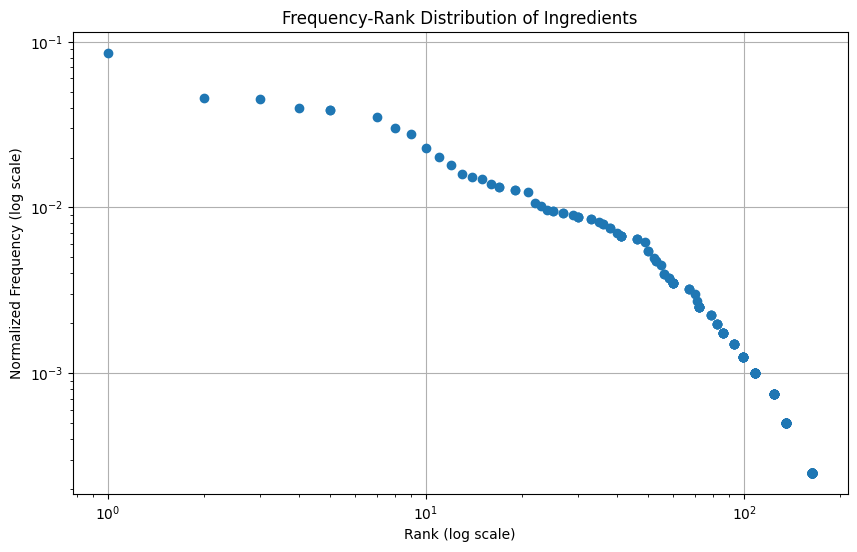

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(ingredient_frequencies['Rank'], ingredient_frequencies['Normalized Frequency'], marker='o', linestyle='none')
plt.xscale('log')
plt.yscale('log')
plt.title('Frequency-Rank Distribution of Ingredients')
plt.xlabel('Rank (log scale)')
plt.ylabel('Normalized Frequency (log scale)')
plt.grid(True)

saving the files


In [71]:
plt.savefig('frequency_rank_distribution.svg')
plt.savefig('frequency_rank_distribution.png')


<Figure size 640x480 with 0 Axes>